# Day 24 - Using a neural network to fit the data

## Artificual neurons

## The PyTorch nn module

### Using `__call__` rather than `forward`

In [1]:
import torch

t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c).unsqueeze(1)
t_u = torch.tensor(t_u).unsqueeze(1)

In [2]:
t_u_mean = t_u.mean()
t_u_std = t_u.std()

t_u_norm = (t_u - t_u_mean) / t_u_std

t_u_mean, t_u_std, t_u_norm

(tensor(51.8000),
 tensor(16.8319),
 tensor([[-0.9565],
         [ 0.2436],
         [ 0.3802],
         [ 1.7883],
         [ 0.2673],
         [-0.1723],
         [-1.0635],
         [-1.7823],
         [-0.2020],
         [ 0.5109],
         [ 0.9862]]))

In [3]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices

(tensor([ 2,  5, 10,  4,  6,  0,  8,  3,  9]), tensor([1, 7]))

In [4]:
train_t_u = t_u[train_indices]
train_t_c = t_c[train_indices]

val_t_u = t_u[val_indices]
val_t_c = t_c[val_indices]

train_t_u_norm = t_u_norm[train_indices]
val_t_u_norm = t_u_norm[val_indices]

In [5]:
import torch.nn as nn

linear_model = nn.Linear(1, 1) # in, out, (bias=True)
linear_model(val_t_u_norm)

tensor([[ 0.0554],
        [-1.0430]], grad_fn=<AddmmBackward0>)

### Returning to the linear model

In [6]:
linear_model.weight, linear_model.bias

(Parameter containing:
 tensor([[0.5422]], requires_grad=True),
 Parameter containing:
 tensor([-0.0767], requires_grad=True))

In [7]:
x = torch.ones(1) # Technically not correct, missing batch dimension!
linear_model(x)

tensor([0.4655], grad_fn=<ViewBackward0>)

In [8]:
x = torch.ones(10, 1)
linear_model(x)

tensor([[0.4655],
        [0.4655],
        [0.4655],
        [0.4655],
        [0.4655],
        [0.4655],
        [0.4655],
        [0.4655],
        [0.4655],
        [0.4655]], grad_fn=<AddmmBackward0>)

* Some advanced models use batch statistics during training, which is an important benefit of batching, in addition to the computational efficiencty

In [9]:
from torch import optim

optimizer = optim.SGD(
    linear_model.parameters(),
    lr=1e-2
)

In [10]:
linear_model.parameters(), list(linear_model.parameters())

(<generator object Module.parameters at 0x78af83c2af80>,
 [Parameter containing:
  tensor([[0.5422]], requires_grad=True),
  Parameter containing:
  tensor([-0.0767], requires_grad=True)])

In [11]:
def loss_fn(t_p, t_c):
    squared_diffs = torch.square(t_p - t_c)
    return squared_diffs.mean()

In [12]:
import numpy as np


def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val,
                  t_c_train, t_c_val, rep_freq=1000):
    train_losses = np.zeros(n_epochs)
    val_losses = np.zeros(n_epochs)
    
    for epoch in range(1, n_epochs + 1):
        t_p_train = model(t_u_train)
        loss_train = loss_fn(t_p_train, t_c_train)
        train_losses[epoch-1] = loss_train.item()

        t_p_val = model(t_u_val)
        loss_val = loss_fn(t_p_val, t_c_val)
        val_losses[epoch-1] = loss_val.item()

        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        if epoch == 1 or epoch == n_epochs or epoch % rep_freq == 0:
            print(f"Epoch {epoch}, Training loss {loss_train.item():.4f},"
                  f" Validation loss {loss_val.item():.4f}")

    return train_losses, val_losses

Epoch 1, Training loss 194.0350, Validation loss 101.8123
Epoch 50, Training loss 26.8687, Validation loss 15.6811
Epoch 100, Training loss 6.0017, Validation loss 4.0684
Epoch 150, Training loss 3.3230, Validation loss 3.3091
Epoch 200, Training loss 2.9305, Validation loss 3.9295
Epoch 250, Training loss 2.8620, Validation loss 4.4941
Epoch 300, Training loss 2.8478, Validation loss 4.8522
Epoch 350, Training loss 2.8446, Validation loss 5.0559
Epoch 400, Training loss 2.8437, Validation loss 5.1664
Epoch 450, Training loss 2.8435, Validation loss 5.2250
Epoch 500, Training loss 2.8435, Validation loss 5.2556
Epoch 550, Training loss 2.8435, Validation loss 5.2714
Epoch 600, Training loss 2.8435, Validation loss 5.2796
Epoch 650, Training loss 2.8435, Validation loss 5.2838
Epoch 700, Training loss 2.8435, Validation loss 5.2859


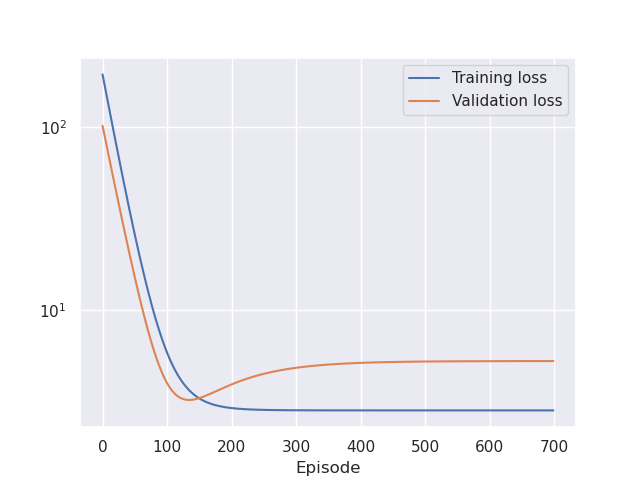

In [13]:
%matplotlib widget
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

linear_model = nn.Linear(1, 1)
optimizer = optim.SGD(
    linear_model.parameters(),
    lr=1e-2
)

tl, vl = training_loop(700, optimizer, linear_model, loss_fn, train_t_u_norm, val_t_u_norm,
                       train_t_c, val_t_c, rep_freq=50)

fig, ax = plt.subplots()
ax.plot(tl, label="Training loss")
ax.plot(vl, label="Validation loss")
ax.set_xlabel("Episode")
ax.set_yscale("log")
ax.legend()
plt.show()

## Finally a neural network

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)
Epoch 1, Training loss 201.6292, Validation loss 104.0526
Epoch 15, Training loss 25.9703, Validation loss 3.6194
Epoch 30, Training loss 12.2290, Validation loss 2.2928
Epoch 45, Training loss 7.8528, Validation loss 1.3357
Epoch 60, Training loss 5.1642, Validation loss 1.1043
Epoch 75, Training loss 3.6148, Validation loss 1.8176
Epoch 90, Training loss 2.7347, Validation loss 2.7877
Epoch 105, Training loss 2.2333, Validation loss 3.7028
Epoch 120, Training loss 1.9451, Validation loss 4.4591
Epoch 135, Training loss 1.7773, Validation loss 5.0413
Epoch 150, Training loss 1.6779, Validation loss 5.4686
Epoch 160, Training loss 1.6346, Validation loss 5.6822


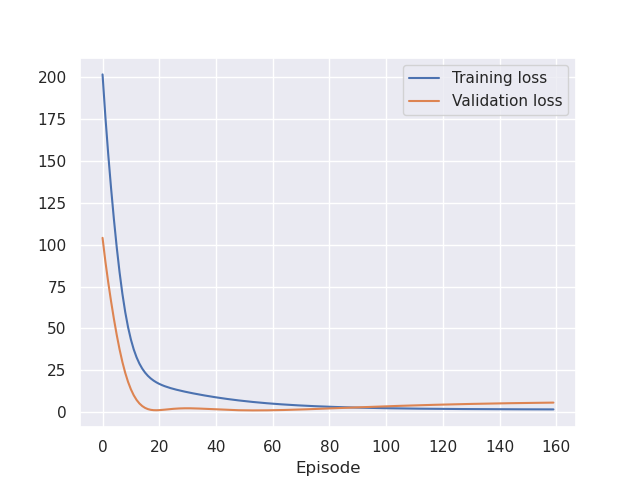

In [14]:
net = nn.Sequential(
    nn.Linear(1, 13),
    nn.Tanh(),
    nn.Linear(13, 1)
)
print(net)
optimizer = optim.SGD(
    net.parameters(),
    lr=1e-2
)

tl, vl = training_loop(160, optimizer, net, loss_fn, train_t_u_norm, val_t_u_norm,
                       train_t_c, val_t_c, rep_freq=15)

fig, ax = plt.subplots()
ax.plot(tl, label="Training loss")
ax.plot(vl, label="Validation loss")
ax.set_xlabel("Episode")
ax.legend()
plt.show()

* We can take a look at our parameters, as well as their shapes, using the handy `named_parameters` method
* This lets us know which layer these parameters each belong to

In [15]:
for name, param in net.named_parameters():
    print(name, param.shape, param)

0.weight torch.Size([13, 1]) Parameter containing:
tensor([[-1.1355],
        [ 0.6007],
        [ 0.3024],
        [-1.2622],
        [-1.1005],
        [-0.5480],
        [-1.2459],
        [-0.0859],
        [ 0.3134],
        [ 0.3354],
        [-0.3391],
        [-1.2368],
        [ 0.3512]], requires_grad=True)
0.bias torch.Size([13]) Parameter containing:
tensor([ 0.6847,  0.3601,  1.3527,  0.8928,  0.6197, -0.3679,  0.8492, -1.5081,
         1.1381,  1.2168, -0.9372,  0.8485,  1.2275], requires_grad=True)
2.weight torch.Size([1, 13]) Parameter containing:
tensor([[-1.7224,  2.2369,  2.5845, -1.6086, -1.7767, -1.9454, -2.3221, -1.2357,
          2.1504,  2.4734, -1.7390, -2.1960,  2.6083]], requires_grad=True)
2.bias torch.Size([1]) Parameter containing:
tensor([2.7942], requires_grad=True)


* It is also possible to use an `OrderedDict` to give `Sequential`s layers custom names

In [16]:
from collections import OrderedDict


net = nn.Sequential(OrderedDict([
    ("hidden_linear", nn.Linear(1, 8)),
    ("hidden_activation", nn.Tanh()),
    ("output_linear", nn.Linear(8, 1))
]))

net

Sequential(
  (hidden_linear): Linear(in_features=1, out_features=8, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=8, out_features=1, bias=True)
)

In [17]:
for name, param in net.named_parameters():
    print(name, param.shape)

hidden_linear.weight torch.Size([8, 1])
hidden_linear.bias torch.Size([8])
output_linear.weight torch.Size([1, 8])
output_linear.bias torch.Size([1])


* We can also access individual parameters through the submodules

In [18]:
net.output_linear.weight

Parameter containing:
tensor([[ 0.0668, -0.2771,  0.0897, -0.3492,  0.0756,  0.1634, -0.3231,  0.1302]],
       requires_grad=True)

* This allows us to take a look at the gradients directly

In [19]:
optimizer = optim.SGD(net.parameters(), lr=1e-3)

training_loop(
    n_epochs = 5000,
    optimizer = optimizer,
    model = net,
    loss_fn = loss_fn,
    t_u_train = train_t_u_norm,
    t_u_val = val_t_u_norm,
    t_c_train = train_t_c,
    t_c_val = val_t_c,
)

print("output", net(val_t_u_norm))
print("answer", val_t_c)
print("hidden", net.hidden_linear.weight.grad)

Epoch 1, Training loss 216.4748, Validation loss 112.4382
Epoch 1000, Training loss 3.2246, Validation loss 4.4686
Epoch 2000, Training loss 1.6924, Validation loss 5.9548
Epoch 3000, Training loss 1.5499, Validation loss 5.9618
Epoch 4000, Training loss 1.5091, Validation loss 6.4611
Epoch 5000, Training loss 1.4846, Validation loss 7.2364
output tensor([[11.2279],
        [-1.3942]], grad_fn=<AddmmBackward0>)
answer tensor([[14.],
        [-4.]])
hidden tensor([[-0.0178],
        [ 0.0457],
        [ 0.0042],
        [-0.0223],
        [-0.0203],
        [ 0.0257],
        [-0.0799],
        [ 0.0259]])


* Finally, we can also plot our model's output, and compare it to the linear ideal

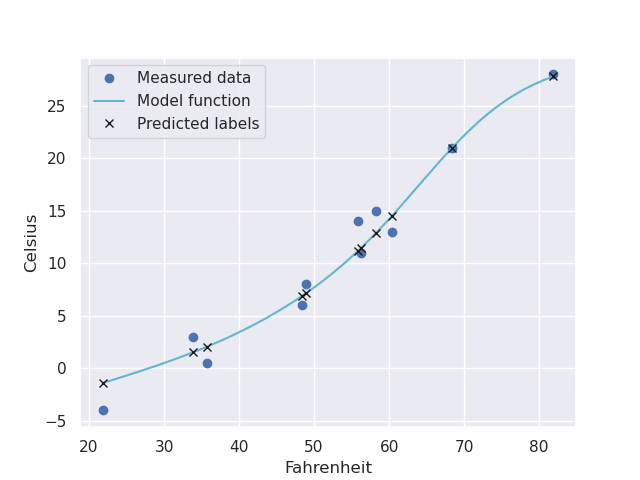

In [20]:
t_u_range = np.linspace(min(t_u), max(t_u))
t_u_range_t = torch.tensor(t_u_range)
t_u_range_norm = (t_u_range_t - t_u_mean) / t_u_std

fig, ax = plt.subplots()
ax.set_xlabel("Fahrenheit")
ax.set_ylabel("Celsius")
ax.plot(t_u, t_c, 'o', label="Measured data")
ax.plot(t_u_range, net(t_u_range_norm).detach().numpy(), 'c-', label="Model function")
ax.plot(t_u, net(t_u_norm).detach().numpy(), 'kx', label="Predicted labels")
ax.legend()
plt.show()

## Exercises

1. Experiment with the number of hidden neurons in our simple neural network model, as well as the learning rate.
    1. What changes result in more linear output from the model?
    1. Can you get the model to obviously overfit the data?

I did not store the results, but I went overboard with the network size, and of course more layers and neurons led to more extreme overfitting. Smaller network led to more linear results.

2. The third-hardest problem in physics is finding a proper wine to celebrate discoveries. Load the wine data from chapter 4, and create a new model with the appropriate number of input parameters.
    1. How long does it take to train compared to the temperature data we have been using?
    1. Can you explain what factors contribute to the training times?
    1. Can you get the loss to decrease while training on this dataset?
    1. How would you go about graphing this dataset?

In [21]:
import csv

wine_path = "./DLPT/data/winequality-white.csv"
wineq_numpy = np.loadtxt(wine_path, dtype=np.float32, delimiter=";", skiprows=1)
wineq = torch.from_numpy(wineq_numpy)

In [22]:
data = wineq[:, :-1]
target = wineq[:, -1].long()

data.shape, target.shape

(torch.Size([4898, 11]), torch.Size([4898]))

In [23]:
target_onehot = torch.zeros(target.shape[0], 10)
target_onehot.scatter_(1, target.unsqueeze(1), 1.0)
target_onehot.shape

torch.Size([4898, 10])

In [24]:
data_mean = torch.mean(data, dim=0)
data_var = torch.var(data, dim=0)
data_normalized = (data - data_mean) / torch.sqrt(data_var)
data_normalized.shape

torch.Size([4898, 11])

In [25]:
n_samples = data.shape[0]
shuffled_indices = torch.randperm(n_samples)

n_val_samples = int(n_samples * 0.1)

train_indices = shuffled_indices[:-n_val_samples]
val_indices = shuffled_indices[-n_val_samples:]

train_indices.shape, val_indices.shape

(torch.Size([4409]), torch.Size([489]))

In [26]:
train_samples = data_normalized[train_indices]
val_samples = data_normalized[val_indices]

train_targets = target_onehot[train_indices]
val_targets = target_onehot[val_indices]

train_samples.shape, train_targets.shape, val_samples.shape, val_targets.shape

(torch.Size([4409, 11]),
 torch.Size([4409, 10]),
 torch.Size([489, 11]),
 torch.Size([489, 10]))

Epoch 1, Training loss 2.2802, Validation loss 2.2821
Epoch 150, Training loss 0.9774, Validation loss 1.0254
Epoch 300, Training loss 0.9365, Validation loss 1.0381
Epoch 450, Training loss 0.9062, Validation loss 1.0320
Epoch 600, Training loss 0.8862, Validation loss 1.0264
Epoch 750, Training loss 0.8751, Validation loss 1.0260
Epoch 900, Training loss 0.8691, Validation loss 1.0222
Epoch 1000, Training loss 0.8662, Validation loss 1.0193


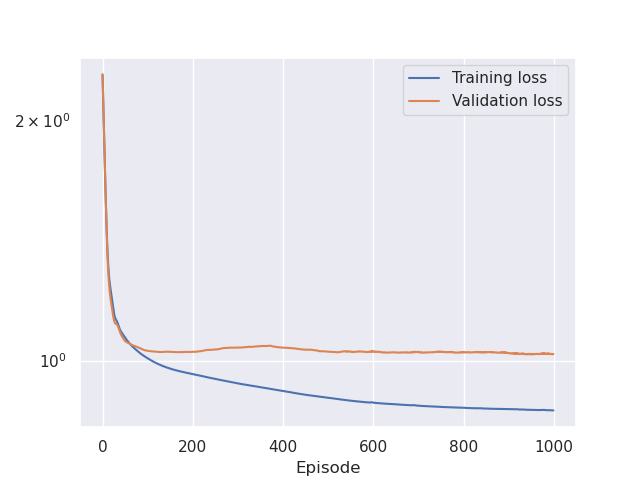

In [37]:
net = nn.Sequential(
    nn.Linear(11, 32),
    nn.ReLU(),
    nn.Linear(32, 10)
)
optimizer = optim.Adam(
    net.parameters(),
    lr=1e-2,
)

loss_fn = nn.CrossEntropyLoss()

tl, vl = training_loop(
    n_epochs = 1000,
    optimizer = optimizer,
    model = net,
    loss_fn = loss_fn,
    t_u_train = train_samples,
    t_c_train = train_targets,
    t_u_val = val_samples,
    t_c_val = val_targets,
    rep_freq=150,
)

fig, ax = plt.subplots()
ax.plot(tl, label="Training loss")
ax.plot(vl, label="Validation loss")
ax.set_xlabel("Episode")
ax.set_yscale("log")
ax.legend()
plt.show()

In [38]:
net.eval()
pred_labels = torch.argmax(net(val_samples), axis=1)
target_labels = torch.argmax(val_targets, axis=1)

(pred_labels == target_labels).sum() / val_targets.shape[0]

tensor(0.5665)

In [39]:
pred_labels = torch.argmax(net(train_samples), axis=1)
target_labels = torch.argmax(train_targets, axis=1)

(pred_labels == target_labels).sum() / train_targets.shape[0]

tensor(0.6292)

It takes a slight bit longer to train on this data, as it has a lot more samples, and more dimensions. Additionally, the network itself now has more parameters to train.